# Introduction

We consider 2D CP(N-1) lattice models with the gauge-free action
$$
S(z) = -\beta \sum_{\left< xy \right>} (|z_x^\dagger z_y|^2 - 1), \qquad \sum_i |z_i|^2 = 1
$$
These models exhibit many of the features of Yang-Mills theory in a lower dimension, providing a useful testing ground of key ideas of flow-based sampling for LQFT. In particular, the focus of this project is to fully explore scaling in the continuum limit. Ideally we would demonstrate a significantly improved scaling of both training time and sampling time.

In [181]:
import analysis as al
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import tqdm.auto as tqdm

In [2]:
%matplotlib widget

In [3]:
device = 'cpu'
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)

In [120]:
def grab(x):
    return x.detach().cpu().numpy()
def wrap(x):
    return (x + np.pi) % (2*np.pi) - np.pi

In [11]:
Nd = 2

# Basic functions

We work with two possible representations of the CP(N-1) variables.

  1. Complex vector $N$-dimensional vector $z_i \in \mathbb{C}$ subject to $\sum_i |z_i|^2 = 1$.
  2. Polar decomposition $z_i = \sqrt{y_i} e^{i\theta_i}$, with $y_i \in \mathbb{R}_{+}, \theta_i \in [-\pi, \pi]$ and $\sum_i y_i = 1$.

In [37]:
def np_to_polar(z):
    y = np.abs(z)**2
    th = np.angle(z)
    return y,th
def np_to_cartesian(y, th):
    z = np.sqrt(y) * np.exp(1j*th)
    return z
def to_polar(z):
    y = z.abs()**2
    th = torch.angle(z)
    return y,th
def to_cartesian(y, th):
    # norm = torch.sqrt(y.sum(dim=-1, keepdim=True))
    z = torch.sqrt(y) * np.exp(1j*th)
    return z

In [41]:
def test_polar_cartesian():
    Nc = 5
    L = 4
    z = np.random.normal(size=(L,L,Nc)) + 1j*np.random.normal(size=(L,L,Nc))
    # test unnormalized
    # z /= np.sqrt(np.sum(np.abs(z)**2, axis=-1, keepdims=True))
    y,th = np_to_polar(z)
    assert np.allclose(z, np_to_cartesian(y, th))
    yp,thp = to_polar(torch.tensor(z))
    assert np.allclose(z, grab(to_cartesian(yp, thp)))
    assert np.allclose(y, grab(yp))
    assert np.allclose(th, grab(thp))
    print('[PASSED test_polar_cartesian]')
# test_polar_cartesian()

The action is implemented over the complex representation. We can always cast to it from underlying polar variables.

In [250]:
def np_action_z(z: np.ndarray, *, beta):
    """CP(N-1) action assuming normalized z"""
    S = 0
    inds = tuple(range(len(z.shape)-Nd-1, len(z.shape)-1))
    assert len(inds) == Nd
    for mu,ind in zip(range(Nd), inds):
        S = S - beta * np.sum(np.abs(np.sum(np.roll(z, -1, axis=ind) * np.conj(z), axis=-1))**2 - 1, axis=inds)
    return S
def action_z(z: torch.Tensor, *, beta):
    """CP(N-1) action assuming normalized z"""
    S = 0
    inds = tuple(range(len(z.shape)-Nd-1, len(z.shape)-1))
    assert len(inds) == Nd
    for mu,ind in zip(range(Nd), inds):
        S = S - beta * torch.sum(torch.abs(
            torch.sum(torch.roll(z, -1, dims=ind) * z.conj(), dim=-1))**2 - 1, dim=inds)
    return S

def action_y_th(y: torch.Tensor, th: torch.Tensor, *, beta):
    """CP(N-1) action given unnoramlized y and th"""
    S = 0
    inds = tuple(range(len(y.shape)-Nd-1, len(y.shape)-1))
    assert len(inds) == Nd
    m = y.sqrt()
    m = m / y.sum(dim=-1, keepdim=True)
    ph = torch.exp(1j*th)
    for mu,ind in zip(range(Nd), inds):
        m_fwd = torch.roll(m, -1, dims=ind)
        ph_fwd = torch.roll(ph, -1, dims=ind)
        local_S_mu = torch.sum(m_fwd * m * ph_fwd.conj() * ph, dim=-1).abs()**2
        S = S - beta * (local_S_mu - 1).sum(inds)
    return S

def action_reg_y(y: torch.Tensor, *, kappa):
    """Action to regulate the sum of ys"""
    # sum over all non-batch indices
    inds = tuple(range(len(y.shape)-Nd-1, len(y.shape)))
    return kappa * y.sum(inds)

In [251]:
def test_batched_action():
    Nc = 5
    L = 4
    bs = (2,3)
    z = np.random.normal(size=bs+(L,L,Nc)) + 1j*np.random.normal(size=bs+(L,L,Nc))
    norm_z = np.sum(np.abs(z)**2, axis=-1, keepdims=True)
    S = np_action_z(z/norm_z, beta=1.0)
    assert S.shape == bs
    Sp = action_z(torch.tensor(z/norm_z), beta=1.0)
    assert np.allclose(grab(Sp), S)
    Spp = action_y_th(*to_polar(torch.tensor(z)), beta=1.0)
    assert np.allclose(grab(Spp), S)
    print('[PASSED test_batched_action]')
test_batched_action()

[PASSED test_batched_action]


In [252]:
def compute_ess(logw):
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg

# RQS

In [19]:
# Spline Coupling Utils
DEFAULT_MIN_BIN_WIDTH = 1e-3
DEFAULT_MIN_BIN_HEIGHT = 1e-3
DEFAULT_MIN_DERIVATIVE = 1e-3
DEFAULT_MIN_LOGJ_ARG = 0.

# all inputs must be >= bin_locations
def searchsorted(bin_locations, inputs, eps: float =1e-5):
    answer =  torch.sum(
        inputs[..., None] >= bin_locations,
        dim=-1
    ) - 1
    return answer



def unconstrained_RQS(inputs, unnormalized_widths, unnormalized_heights,
                      unnormalized_derivatives, *, inverse,
                      tail_bound, min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                      min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                      min_derivative=DEFAULT_MIN_DERIVATIVE):
    # reshape flat
    input_shape = inputs.shape
    inputs = torch.flatten(inputs, start_dim=1)
    unnormalized_widths = torch.flatten(unnormalized_widths, start_dim=2) #shape K
    unnormalized_heights = torch.flatten(unnormalized_heights, start_dim=2) #shape K
    unnormalized_derivatives = torch.flatten(unnormalized_derivatives, start_dim=2) #shape K-1
    unnormalized_widths = torch.transpose(unnormalized_widths, 1, 2)
    unnormalized_heights = torch.transpose(unnormalized_heights, 1, 2)
    unnormalized_derivatives = torch.transpose(unnormalized_derivatives, 1, 2)


    inside_intvl_mask = (inputs >= -tail_bound) & (inputs <= tail_bound)
    outside_interval_mask = ~inside_intvl_mask

    outputs = torch.zeros_like(inputs)
    logabsdet = torch.zeros_like(inputs)

    unnormalized_derivatives = F.pad(unnormalized_derivatives, pad=(1, 1))
    constant = np.log(np.exp(1 - min_derivative) - 1)
    unnormalized_derivatives[..., 0] = constant
    unnormalized_derivatives[..., -1] = constant

    outputs[outside_interval_mask] = inputs[outside_interval_mask]
    logabsdet[outside_interval_mask] = 0

    tail_bound = torch.tensor([tail_bound], device=inputs.device) if not torch.is_tensor(tail_bound) else tail_bound
    tail_bound = torch.flatten(tail_bound.broadcast_to(input_shape), start_dim=1)[inside_intvl_mask]

    outputs[inside_intvl_mask], logabsdet[inside_intvl_mask] = RQS(
        inputs=inputs[inside_intvl_mask],
        unnormalized_widths=unnormalized_widths[inside_intvl_mask, :],
        unnormalized_heights=unnormalized_heights[inside_intvl_mask, :],
        unnormalized_derivatives=unnormalized_derivatives[inside_intvl_mask, :],
        inverse=inverse,
        left=-tail_bound, right=tail_bound, bottom=-tail_bound, top=tail_bound,
        min_bin_width=min_bin_width,
        min_bin_height=min_bin_height,
        min_derivative=min_derivative
    )

    # reshape dimensionful
    outputs = outputs.view(input_shape)
    logabsdet = logabsdet.view(input_shape)
    return outputs, logabsdet


def circle_RQS(inputs, unnormalized_widths, unnormalized_heights,
                      unnormalized_derivatives, *, inverse,
                      circle_range_left, circle_range_right,
                      interval_normalize = True,
                      min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                      min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                      min_derivative=DEFAULT_MIN_DERIVATIVE):
    min_bin_width = max(min_bin_width, DEFAULT_MIN_BIN_WIDTH)
    min_bin_height = max(min_bin_height, DEFAULT_MIN_BIN_HEIGHT)
    min_derivative = max(min_derivative, DEFAULT_MIN_DERIVATIVE)

    input_shape = inputs.shape  # [bs, Ls, ...]
    inputs = torch.flatten(inputs, start_dim=1)  # -> [bs, V]
    unnormalized_widths = torch.flatten(unnormalized_widths, start_dim=2)  # [bs, K, Ls, ...] -> [bs, K, V]
    unnormalized_heights = torch.flatten(unnormalized_heights, start_dim=2)
    unnormalized_derivatives = torch.flatten(unnormalized_derivatives, start_dim=2)
    unnormalized_widths = torch.transpose(unnormalized_widths, 1, 2)  # -> [bs, V, K]
    unnormalized_heights = torch.transpose(unnormalized_heights, 1, 2)
    unnormalized_derivatives = torch.transpose(unnormalized_derivatives, 1, 2)  # -> [bs, V, K]

    unnormalized_derivatives = F.pad(unnormalized_derivatives, pad=(0, 1))
    unnormalized_derivatives[..., -1] = unnormalized_derivatives[..., 0]


    circle_range_left, circle_range_right = map(lambda x: torch.tensor([x], device=inputs.device)
        if not torch.is_tensor(x) else x, [circle_range_left, circle_range_right])
    circle_range_left, circle_range_right = map(lambda x: torch.flatten(x.broadcast_to(input_shape), start_dim=1),
        [circle_range_left, circle_range_right])
    outputs, logabsdet = RQS(
        inputs=inputs,
        unnormalized_widths=unnormalized_widths,
        unnormalized_heights=unnormalized_heights,
        unnormalized_derivatives=unnormalized_derivatives,
        inverse=inverse,
        left=circle_range_left, right=torch.nextafter(circle_range_right, torch.tensor(float('inf'))),
        bottom=circle_range_left, top=circle_range_right,
        interval_normalize=interval_normalize,
        min_bin_width=min_bin_width,
        min_bin_height=min_bin_height,
        min_derivative=min_derivative
    )

    outputs = outputs.view(input_shape)
    logabsdet = logabsdet.view(input_shape)
    return outputs, logabsdet


def open_RQS(inputs, unnormalized_widths, unnormalized_heights,
                      unnormalized_derivatives, *, inverse,
                      left=0., right=1.,bottom=0., top=1.,
                      min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                      min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                      min_derivative=DEFAULT_MIN_DERIVATIVE):
    min_bin_width = max(min_bin_width, DEFAULT_MIN_BIN_WIDTH)
    min_bin_height = max(min_bin_height, DEFAULT_MIN_BIN_HEIGHT)
    min_derivative = max(min_derivative, DEFAULT_MIN_DERIVATIVE)

    input_shape = inputs.shape
    inputs = torch.flatten(inputs, start_dim=1)
    unnormalized_widths = torch.flatten(unnormalized_widths, start_dim=2)
    unnormalized_heights = torch.flatten(unnormalized_heights, start_dim=2) #shape K
    unnormalized_derivatives = torch.flatten(unnormalized_derivatives, start_dim=2) #shape K+1
    unnormalized_widths = torch.transpose(unnormalized_widths, 1, 2)
    unnormalized_heights = torch.transpose(unnormalized_heights, 1, 2)
    unnormalized_derivatives = torch.transpose(unnormalized_derivatives, 1, 2)

    left1, right1, bottom1, top1 = map(lambda x: torch.tensor([x], device=inputs.device)
        if not torch.is_tensor(x) else x, [left, right, bottom, top])

    outputs, logabsdet = RQS(
        inputs=inputs,
        unnormalized_widths=unnormalized_widths,
        unnormalized_heights=unnormalized_heights,
        unnormalized_derivatives=unnormalized_derivatives,
        inverse=inverse,
        left=torch.flatten(left1.broadcast_to(input_shape), start_dim=1),
        right=torch.flatten(right1.broadcast_to(input_shape), start_dim=1),
        bottom=torch.flatten(bottom1.broadcast_to(input_shape), start_dim=1),
        top=torch.flatten(top1.broadcast_to(input_shape), start_dim=1),
        min_bin_width=min_bin_width,
        min_bin_height=min_bin_height,
        min_derivative=min_derivative
    )

    outputs = outputs.view(input_shape)
    logabsdet = logabsdet.view(input_shape)
    return outputs, logabsdet


# RQS acting on the positive real axis; for values outside of
# [min_value, max_value] applies the identity.
def positive_RQS(inputs, unnormalized_widths, unnormalized_heights,
                 unnormalized_derivatives, *, inverse,
                 min_value, max_value,
                 min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                 min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                 min_derivative=DEFAULT_MIN_DERIVATIVE):
    min_bin_width = max(min_bin_width, DEFAULT_MIN_BIN_WIDTH)
    min_bin_height = max(min_bin_height, DEFAULT_MIN_BIN_HEIGHT)
    min_derivative = max(min_derivative, DEFAULT_MIN_DERIVATIVE)

    input_shape = inputs.shape
    inputs = torch.flatten(inputs, start_dim=1)
    unnormalized_widths = torch.flatten(unnormalized_widths, start_dim=2)
    unnormalized_heights = torch.flatten(unnormalized_heights, start_dim=2) #shape K
    unnormalized_derivatives = torch.flatten(unnormalized_derivatives, start_dim=2) #shape K+1
    unnormalized_widths = torch.transpose(unnormalized_widths, 1, 2)
    unnormalized_heights = torch.transpose(unnormalized_heights, 1, 2)
    unnormalized_derivatives = torch.transpose(unnormalized_derivatives, 1, 2)

    inside_intvl_mask = (inputs >= min_value) & (inputs <= max_value)
    outside_interval_mask = ~inside_intvl_mask

    outputs = torch.zeros_like(inputs)
    logabsdet = torch.zeros_like(inputs)

    unnormalized_derivatives = F.pad(unnormalized_derivatives, pad=(1, 1))
    constant = np.log(np.exp(1 - min_derivative) - 1)
    unnormalized_derivatives[..., 0] = constant
    unnormalized_derivatives[..., -1] = constant

    outputs[outside_interval_mask] = inputs[outside_interval_mask]
    logabsdet[outside_interval_mask] = 0

    outputs[inside_intvl_mask], logabsdet[inside_intvl_mask] = RQS(
        inputs=inputs[inside_intvl_mask],
        unnormalized_widths=unnormalized_widths[inside_intvl_mask, :],
        unnormalized_heights=unnormalized_heights[inside_intvl_mask, :],
        unnormalized_derivatives=unnormalized_derivatives[inside_intvl_mask, :],
        inverse=inverse,
        left=min_value, right=max_value,
        bottom=min_value, top=max_value,
        min_bin_width=min_bin_width,
        min_bin_height=min_bin_height,
        min_derivative=min_derivative
    )

    outputs = outputs.view(input_shape)
    logabsdet = logabsdet.view(input_shape)
    return outputs, logabsdet

# @torch.jit.script
def RQS(inputs, unnormalized_widths, unnormalized_heights,
        unnormalized_derivatives, inverse : bool =False, left: float =0., right:float =1.,
        bottom:float =0., top:float=1., interval_normalize:bool = True,
        min_bin_width:float=DEFAULT_MIN_BIN_WIDTH,
        min_bin_height:float=DEFAULT_MIN_BIN_HEIGHT,
        min_derivative:float=DEFAULT_MIN_DERIVATIVE):
    '''
    input [bs, V]
    widths/heights [bs, V, K]
    derivatives [bs, V, K+1]
    '''
    # if not inverse:
    #     assert torch.all(inputs >= left[...,0]), f'outside left interval: {inputs[inputs>left[...,0]]} < {left[...,0][inputs>left[...,0]]}'
    #     assert torch.all(inputs <= right[...,0]), f'outside right interval: {torch.max(inputs)} > {right}'
    # else:
    #     assert torch.all(inputs >= bottom[...,0]), f'outside left interval: {inputs[inputs>left[...,0]]} < {left[...,0][inputs>left[...,0]]}'
    #     assert torch.all(inputs <= top[...,0]), f'outside right interval: {torch.max(inputs)} > {right}'

    if not inverse:
        assert torch.all(inputs >= left), f'outside left interval: {inputs[~(inputs>=left)]} < {left[~(inputs>=left)]}'
        assert torch.all(inputs <= right), f'outside right interval: {inputs[~(inputs<=right)]} < {right[~(inputs<=right)]}'
    else:
        assert torch.all(inputs >= bottom), f'outside left interval: {inputs[~(inputs<=left)]} < {left[~(inputs<=left)]}'
        assert torch.all(inputs <= top), f'outside right interval: {inputs[~(inputs<=top)]} > {top[~(inputs<=top)]}'


    num_bins = unnormalized_widths.shape[-1]

    assert min_bin_width * num_bins <= 1.0, \
        'Minimal bin width too large for the number of bins'
    assert min_bin_height * num_bins <= 1.0, \
        'Minimal bin height too large for the number of bins'

    # trick for numerical stability of stability softmax
    if interval_normalize:
        unnormalized_widths = unnormalized_widths - torch.max(unnormalized_widths, dim=-1, keepdim=True)[0]
        unnormalized_widths = F.softmax(unnormalized_widths, dim=-1)  # possible numerical issues
    widths = unnormalized_widths
    widths = min_bin_width + (1 - min_bin_width * num_bins) * widths
    cumwidths = torch.cumsum(widths, dim=-1)
    cumwidths = F.pad(cumwidths, pad=(1, 0), mode='constant', value=0.0)  # [bs, V, K+1]
    cumwidths = (right - left).unsqueeze(-1) * cumwidths + left.unsqueeze(-1)
    cumwidths[..., 0] = left
    cumwidths[..., -1] = right
    widths = cumwidths[..., 1:] - cumwidths[..., :-1]  # [bs, V, K]

    # The offset is such that the normalized knot slope will be equal to 1
    # whenever the unnormalized knot slope is equal to 0.
    dir_offset = torch.log(torch.exp(torch.ones_like(unnormalized_derivatives) - min_derivative) - 1)
    derivatives =  min_derivative + F.softplus(unnormalized_derivatives + dir_offset)  # stable

    if interval_normalize:
        # trick for numerical stability of stability softmax
        unnormalized_heights = unnormalized_heights - torch.max(unnormalized_heights, dim=-1, keepdim=True)[0]
        unnormalized_heights = F.softmax(unnormalized_heights, dim=-1)
    heights = unnormalized_heights
    heights = min_bin_height + (1 - min_bin_height * num_bins) * heights
    cumheights = torch.cumsum(heights, dim=-1)
    cumheights = F.pad(cumheights, pad=(1, 0), mode='constant', value=0.0)
    cumheights = (top - bottom).unsqueeze(-1) * cumheights + bottom.unsqueeze(-1)
    cumheights[..., 0] = bottom
    cumheights[..., -1] = top
    heights = cumheights[..., 1:] - cumheights[..., :-1]

    # for stability do not compare with end of interval
    if not inverse:
        bin_idx = searchsorted(cumwidths[..., :-1], inputs)[..., None]
    else:
        bin_idx = searchsorted(cumheights[..., :-1], inputs)[..., None]  # [bs, V, 1]

    input_cumwidths = cumwidths.gather(-1, bin_idx)[..., 0]  # [bs, V]
    input_bin_widths = widths.gather(-1, bin_idx)[..., 0]

    input_cumheights = cumheights.gather(-1, bin_idx)[..., 0]
    delta = heights / widths
    input_delta = delta.gather(-1, bin_idx)[..., 0]

    input_derivatives = derivatives.gather(-1, bin_idx)[..., 0]
    input_derivatives_plus_one = torch.roll(derivatives, -1, -1).gather(-1, bin_idx)[..., 0]

    input_heights = heights.gather(-1, bin_idx)[..., 0]

    if not inverse:
        theta = (inputs - input_cumwidths) / input_bin_widths
        # theta should be in range [0, 1] to avoid NaNs later. This can happen because
        # of small floating point issues or when inputs is outside of the range
        theta = torch.clamp(theta, 0., 1.)
        theta_one_minus_theta = theta * (1 - theta)

        numerator = input_heights * (input_delta * theta.pow(2)
                    + input_derivatives * theta_one_minus_theta)
        denominator = input_delta + ((input_derivatives
                      + input_derivatives_plus_one - 2 * input_delta)
                      * theta_one_minus_theta)
        outputs = input_cumheights + numerator / denominator

        derivative_numerator = (
            input_delta.pow(2) *
            (input_derivatives_plus_one * theta.pow(2)
             + 2 * input_delta * theta_one_minus_theta
             + input_derivatives * (1 - theta).pow(2)))
        # The logdet is a sum of 3 logs. It is easy to see that the inputs of the
        # first two logs are guaranteed to be positive because we ensured that z is in
        # [0, 1]. This is also true of the log(denominator) because:
        # denominator
        # == bin_slope + (knot_slopes[i+1] + knot_slopes[i] - 2 * bin_slope) * z*(1-z)
        # >= bin_slope - 2 * bin_slope * z * (1-z)
        # >= bin_slope - 2 * bin_slope * (1/4)
        # == bin_slope / 2
        logdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, logdet
    else:
        a = (((inputs - input_cumheights) * (input_derivatives
            + input_derivatives_plus_one - 2 * input_delta)
            + input_heights * (input_delta - input_derivatives)))
        b = (input_heights * input_derivatives - (inputs - input_cumheights)
            * (input_derivatives + input_derivatives_plus_one
            - 2 * input_delta))
        c = - input_delta * (inputs - input_cumheights)

        discriminant = b.pow(2) - 4 * a * c
        assert (discriminant >= 0).all(), f"Discriminant < 0: {discriminant[discriminant<0]}"

        root = (2 * c) / (-b - torch.sqrt(discriminant))
        outputs = root * input_bin_widths + input_cumwidths

        theta_one_minus_theta = root * (1 - root)
        denominator = (input_delta +
                       ((input_derivatives + input_derivatives_plus_one
                         - 2 * input_delta) * theta_one_minus_theta))
        derivative_numerator = (
            input_delta.pow(2)
            * (input_derivatives_plus_one * root.pow(2)
               + 2 * input_delta * theta_one_minus_theta
               + input_derivatives * (1 - root).pow(2)))
        # logabsdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        # for numerical stability
        det = derivative_numerator / denominator**2
        safe_det = torch.where(det > 0, det, torch.zeros_like(det))
        logabsdet = torch.where(det > 0,
            torch.log(safe_det),
            torch.zeros_like(det))

        return outputs, -logabsdet


def open_RQS_tensor_limits(inputs, unnormalized_widths, unnormalized_heights,
                      unnormalized_derivatives, *, inverse,
                      left, right, bottom, top,
                      min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                      min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                      min_derivative=DEFAULT_MIN_DERIVATIVE):
    min_bin_width = max(min_bin_width, DEFAULT_MIN_BIN_WIDTH)
    min_bin_height = max(min_bin_height, DEFAULT_MIN_BIN_HEIGHT)
    min_derivative = max(min_derivative, DEFAULT_MIN_DERIVATIVE)

    input_shape = inputs.shape
    inputs = torch.flatten(inputs, start_dim=1)
    unnormalized_widths = torch.flatten(unnormalized_widths, start_dim=2) #shape K
    unnormalized_heights = torch.flatten(unnormalized_heights, start_dim=2) #shape K
    unnormalized_derivatives = torch.flatten(unnormalized_derivatives, start_dim=2) #shape K+1
    unnormalized_widths = torch.transpose(unnormalized_widths, 1, 2)
    unnormalized_heights = torch.transpose(unnormalized_heights, 1, 2)
    unnormalized_derivatives = torch.transpose(unnormalized_derivatives, 1, 2)


    reshaped_left = torch.flatten(left, start_dim=2) # [nConf, 1, Lx, Ly, ..] -> [nConf, 1, V]
    reshaped_right = torch.flatten(right, start_dim=2)
    reshaped_bottom = torch.flatten(bottom, start_dim=2)
    reshaped_top = torch.flatten(top, start_dim=2)
    reshaped_left = torch.transpose(left, 1, 2)  # [nConf, 1, V] -> [nConf, V, 1]
    reshaped_right = torch.transpose(right, 1, 2)  #last dim - K or channels emulated
    reshaped_bottom = torch.transpose(bottom, 1, 2)
    reshaped_top = torch.transpose(top, 1, 2)

    outputs, logabsdet = RQS_tensor_limits(
        inputs=inputs,
        unnormalized_widths=unnormalized_widths,
        unnormalized_heights=unnormalized_heights,
        unnormalized_derivatives=unnormalized_derivatives,
        inverse=inverse,
        left=reshaped_left, right=reshaped_right,
        bottom=reshaped_bottom, top=reshaped_top,
        min_bin_width=min_bin_width,
        min_bin_height=min_bin_height,
        min_derivative=min_derivative
    )

    outputs = outputs.view(input_shape)
    logabsdet = logabsdet.view(input_shape)
    return outputs, logabsdet

def RQS_tensor_limits(inputs, unnormalized_widths, unnormalized_heights,
        unnormalized_derivatives, inverse=False, left=0., right=1.,
        bottom=0., top=1., min_bin_width=DEFAULT_MIN_BIN_WIDTH,
        min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
        min_derivative=DEFAULT_MIN_DERIVATIVE):
    # if torch.min(inputs) < left or torch.max(inputs) > right:
    if torch.any(inputs < left) or torch.any(inputs > right):
        raise ValueError("Input outside domain")

    num_bins = unnormalized_widths.shape[-1]

    if min_bin_width * num_bins > 1.0:
        raise ValueError('Minimal bin width too large for the number of bins')
    if min_bin_height * num_bins > 1.0:
        raise ValueError('Minimal bin height too large for the number of bins')

    widths = F.softmax(unnormalized_widths, dim=-1)
    widths = min_bin_width + (1 - min_bin_width * num_bins) * widths
    cumwidths = torch.cumsum(widths, dim=-1)
    cumwidths = (right - left) * cumwidths + left
    cumwidths = F.pad(cumwidths, pad=(1, 0), mode='constant', value=0.0)
    cumwidths[..., 0] = left.squeeze(-1)
    cumwidths[..., -1] = right.squeeze(-1)
    widths = cumwidths[..., 1:] - cumwidths[..., :-1]

    derivatives =  min_derivative + F.softplus(unnormalized_derivatives)

    heights = F.softmax(unnormalized_heights, dim=-1)
    heights = min_bin_height + (1 - min_bin_height * num_bins) * heights
    cumheights = torch.cumsum(heights, dim=-1)
    cumheights = (top - bottom) * cumheights + bottom
    cumheights = F.pad(cumheights, pad=(1, 0), mode='constant', value=0.0)
    cumheights[..., 0] = bottom.squeeze(-1)
    cumheights[..., -1] = top.squeeze(-1)
    heights = cumheights[..., 1:] - cumheights[..., :-1]

    if inverse:
        bin_idx = searchsorted(cumheights, inputs)[..., None]
    else:
        bin_idx = searchsorted(cumwidths, inputs)[..., None]

    input_cumwidths = cumwidths.gather(-1, bin_idx)[..., 0]
    input_bin_widths = widths.gather(-1, bin_idx)[..., 0]

    input_cumheights = cumheights.gather(-1, bin_idx)[..., 0]
    delta = heights / widths
    input_delta = delta.gather(-1, bin_idx)[..., 0]

    input_derivatives = derivatives.gather(-1, bin_idx)[..., 0]
    input_derivatives_plus_one = torch.roll(derivatives, -1, -1).gather(-1, bin_idx)[..., 0]

    input_heights = heights.gather(-1, bin_idx)[..., 0]

    if inverse:
        a = (((inputs - input_cumheights) * (input_derivatives
            + input_derivatives_plus_one - 2 * input_delta)
            + input_heights * (input_delta - input_derivatives)))
        b = (input_heights * input_derivatives - (inputs - input_cumheights)
            * (input_derivatives + input_derivatives_plus_one
            - 2 * input_delta))
        c = - input_delta * (inputs - input_cumheights)

        discriminant = b.pow(2) - 4 * a * c
        assert (discriminant >= 0).all()

        root = (2 * c) / (-b - torch.sqrt(discriminant))
        outputs = root * input_bin_widths + input_cumwidths

        theta_one_minus_theta = root * (1 - root)
        denominator = (input_delta +
                       ((input_derivatives + input_derivatives_plus_one
                         - 2 * input_delta) * theta_one_minus_theta))
        derivative_numerator = (
            input_delta.pow(2)
            * (input_derivatives_plus_one * root.pow(2)
               + 2 * input_delta * theta_one_minus_theta
               + input_derivatives * (1 - root).pow(2)))
        logabsdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, -logabsdet
    else:
        theta = (inputs - input_cumwidths) / input_bin_widths
        theta_one_minus_theta = theta * (1 - theta)

        numerator = input_heights * (input_delta * theta.pow(2)
                    + input_derivatives * theta_one_minus_theta)
        denominator = input_delta + ((input_derivatives
                      + input_derivatives_plus_one - 2 * input_delta)
                      * theta_one_minus_theta)
        outputs = input_cumheights + numerator / denominator

        derivative_numerator = (
            input_delta.pow(2) *
            (input_derivatives_plus_one * theta.pow(2)
             + 2 * input_delta * theta_one_minus_theta
             + input_derivatives * (1 - theta).pow(2)))
        logabsdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, logabsdet

# Coupling Layer, Prior, Flow

In [260]:
class CouplingLayer(torch.nn.Module):
    def __init__(self, Nc, K, max_y):
        super().__init__()
        self.Nc = Nc
        self.K = K
        self.max_y = max_y
        kwargs_pad = dict(padding=1, padding_mode='circular')
        n_y = Nc
        n_th = 2 * Nc
        n_h = 128
        ker_size = 3
        n_out_th = (3 * K + 1) * Nc # circ spline params plus offset
        n_out_y = (3 * K - 1) * Nc # open spline params
        self.net_th = torch.nn.Sequential(
            torch.nn.Conv2d(n_y, n_h, ker_size, **kwargs_pad),
            torch.nn.SiLU(),
            torch.nn.Conv2d(n_h, n_h, ker_size, **kwargs_pad),
            torch.nn.SiLU(),
            torch.nn.Conv2d(n_h, n_out_th, ker_size, **kwargs_pad),
        )
        self.net_y = torch.nn.Sequential(
            torch.nn.Conv2d(n_th, n_h, ker_size, **kwargs_pad),
            torch.nn.SiLU(),
            torch.nn.Conv2d(n_h, n_h, ker_size, **kwargs_pad),
            torch.nn.SiLU(),
            torch.nn.Conv2d(n_h, n_out_y, ker_size, **kwargs_pad),
        )

    def forward(self, y, th, inverse=False):
        assert y.shape[-1] == self.Nc and th.shape[-1] == self.Nc
        assert y.shape == th.shape
        # move channel axis
        y = y.moveaxis(-1, 1)
        th = th.moveaxis(-1, 1)
        
        # transform y (conditioned on th)
        def transform_y():
            nonlocal y, th
            inp_th = torch.cat((torch.cos(th), torch.sin(th)), dim=1)
            out_y_params = self.net_y(inp_th).view(
                inp_th.shape[0], 3*self.K-1, self.Nc, *inp_th.shape[2:])
            W, H, D = torch.split(out_y_params, self.K, dim=1)
            assert D.shape[1] == self.K-1
            y, logJ1 = positive_RQS(
                y, W, H, D, inverse=inverse, min_value=torch.tensor(0.0), max_value=torch.tensor(self.max_y)
            )
            return logJ1

        # transform th (conditioned on y)
        def transform_th():
            nonlocal y, th
            out_th_params = self.net_th(y).view(
                y.shape[0], 3*self.K+1, self.Nc, *y.shape[2:])
            W, H, D = torch.split(out_th_params[:,:-1], self.K, dim=1)
            assert D.shape[1] == self.K
            shift = out_th_params[:,-1]
            if inverse:
                th = wrap(th - shift)
            assert torch.all(th <= np.pi) and torch.all(th >= -np.pi)
            th, logJ2 = circle_RQS(
                th, W, H, D, inverse=inverse,
                circle_range_left=torch.tensor(-np.pi), circle_range_right=torch.tensor(np.pi),
                min_bin_width=0.1/self.K, min_bin_height=0.1/self.K
            )
            if not inverse:
                th = wrap(th + shift)
            return logJ2

        if not inverse:
            logJ1 = transform_y()
            logJ2 = transform_th()
        else:
            logJ2 = transform_th()
            logJ1 = transform_y()

        # move channel axis back
        y = y.moveaxis(1, -1)
        th = wrap(th.moveaxis(1, -1))

        inds = tuple(range(1, len(logJ1.shape)))
        logJ = (logJ1 + logJ2).sum(inds)

        return y, th, logJ

In [261]:
class SequentialFlow(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = torch.nn.ModuleList(layers)
    def forward(self, *fields, inverse=False):
        logJ = torch.zeros(fields[0].shape[0])
        for i,layer in enumerate(self.layers):
            (*fields, logJi) = layer(*fields, inverse=inverse)
            logJ = logJ + logJi
        return (*fields, logJ)

In [262]:
class GaussianPrior(torch.nn.Module):
    def __init__(self, Nc, L):
        super().__init__()
        self.field_shape = (L,)*Nd + (Nc,)
        self.dist_y = torch.distributions.exponential.Exponential(1.0).expand(self.field_shape)
        self.dist_th = torch.distributions.uniform.Uniform(-np.pi, np.pi).expand(self.field_shape)
    def sample_n(self, batch_size):
        y = self.dist_y.sample((batch_size,))
        th = self.dist_th.sample((batch_size,))
        assert y.shape == (batch_size,) + self.field_shape
        assert th.shape == (batch_size,) + self.field_shape
        return y, th
    def log_prob(self, y, th):
        inds = tuple(range(1, len(y.shape)))
        logr = (self.dist_y.log_prob(y) + self.dist_th.log_prob(th)).sum(inds)
        assert len(logr.shape) == 1
        assert logr.shape[0] == y.shape[0]
        return logr

In [263]:
def make_model(Nc, L, *, K=5, y_max=10.0):
    prior = GaussianPrior(Nc, L)
    layers = [
        CouplingLayer(Nc, K, y_max)
    ]*4
    flow = SequentialFlow(layers)
    return prior, flow
Nc = 3
L = 4
batch_size = 1
prior, flow = make_model(Nc, L)
y, th = prior.sample_n(batch_size)
fy, fth, logJ = flow(y, th, inverse=False)
yp, thp, logJp = flow(fy, fth, inverse=True)
assert torch.allclose(y, yp)
assert torch.allclose(th, thp)
assert torch.allclose(logJ, -logJp)

# Training

In [264]:
def train_step(model, opt, sched, *, action, batch_size):
    opt.zero_grad()
    prior, flow = model
    r = prior.sample_n(batch_size)
    (*x, logJ) = flow(*r, inverse=False)
    flow.requires_grad_(False)
    (*rp, logJ2) = flow(*x, inverse=True)
    flow.requires_grad_(True)
    if not torch.allclose(r[0], rp[0]):
        print(f'WARNING: diff {(r[0]-rp[0]).abs().sum()}')
    if not torch.allclose(r[1], rp[1]):
        print(f'WARNING: diff {wrap(r[1]-rp[1]).abs().sum()}')
    assert torch.allclose(logJ, -logJ2)
    logr = prior.log_prob(*rp)
    logq = logr + logJ2
    logp = -action(*x)
    assert len(logq.shape) == 1
    assert logq.shape == logp.shape
    loss = (logq - logp).sum()
    np_loss = grab(loss)
    ess = grab(compute_ess(logp - logq))
    loss.backward()
    g = grab(torch.nn.utils.clip_grad_norm_(model[1].parameters(), float('inf')))
    opt.step()
    sched.step(loss)
    return dict(loss=np_loss, g=g, ess=ess)

In [265]:
def run_train_epoch(model, opt, sched, *, action, n_batch, batch_size):
    hist = {}
    for i in tqdm.tqdm(range(n_batch), leave=False):
        res = train_step(model, opt, sched, action=action, batch_size=batch_size)
        for k in res:
            if k not in hist: hist[k] = []
            hist[k].append(res[k])
    return hist

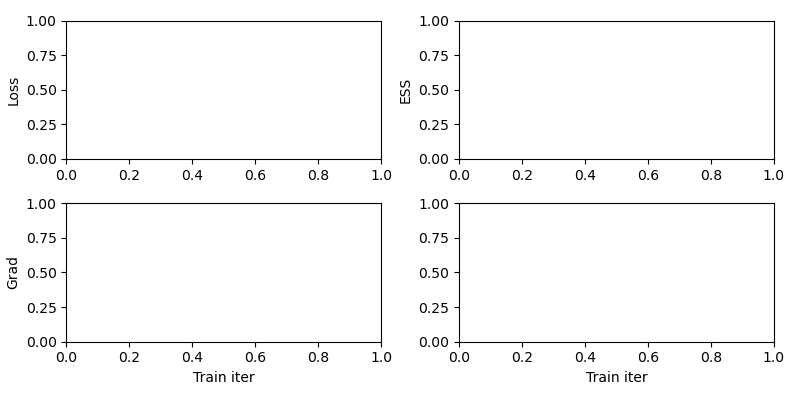

In [266]:
fig, axes = plt.subplots(2,2, figsize=(8,4))
axes[0,0].set_ylabel('Loss')
axes[1,0].set_ylabel('Grad')
axes[1,0].set_xlabel('Train iter')
axes[0,1].set_ylabel('ESS')
axes[1,1].set_xlabel('Train iter')
fig.set_tight_layout(True)
plt.show()

In [267]:
def do_train(res):
    Nc = 3
    L = 2
    batch_size = 1024
    beta = 1.0
    n_epoch = 10
    n_batch = 20
    model = make_model(Nc, L)
    action = lambda y,th: action_y_th(y, th, beta=beta) + action_reg_y(y, kappa=1.0)
    all_hist = dict()
    opt = torch.optim.Adam(model[1].parameters(), lr=1e-4)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=300)
    line_loss, line_grad = None, None
    for i in tqdm.tqdm(range(n_epoch)):
        hist = run_train_epoch(model, opt, sched, action=action, n_batch=n_batch, batch_size=batch_size)
        lr = opt.param_groups[0]["lr"]
        print(f'LR={lr}')
        if lr < 1e-6:
            break
        for k in hist:
            if k not in all_hist:
                all_hist[k] = []
            all_hist[k] = np.concatenate([all_hist[k], hist[k]])
        # update plots
        if line_loss is not None:
            line_loss.set_xdata(np.arange(len(all_hist['loss'])))
            line_loss.set_ydata(all_hist['loss'])
            line_grad.set_xdata(np.arange(len(all_hist['g'])))
            line_grad.set_ydata(all_hist['g'])
            line_ess.set_xdata(np.arange(len(all_hist['ess'])))
            line_ess.set_ydata(all_hist['ess'])
        else:
            line_loss, = axes[0,0].plot(all_hist['loss'])
            line_grad, = axes[1,0].plot(all_hist['g'])
            line_ess, = axes[0,1].plot(all_hist['ess'])
        for ax in axes.flatten():
            ax.relim()
            ax.autoscale_view()
        fig.canvas.draw()
        res['model'] = model
        res['opt'] = opt
        res['all_hist'] = all_hist
res = {}
do_train(res)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


  0%|          | 0/20 [00:00<?, ?it/s]

LR=0.0001


In [223]:
torch.save(res['model'], 'cpn_model_L2.pt')

est_ess=(0.6250025165872296, 0.028978313367001237)
est_S=(-7.569325082384463, 0.011054914206598968)


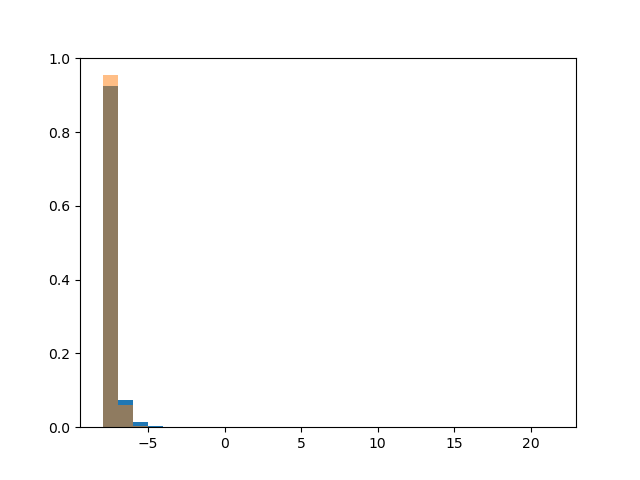

In [249]:
def eval_model(model, *, beta=1.0, batch_size=1024):
    prior, flow = model
    x = prior.sample_n(batch_size)
    logr = prior.log_prob(*x)
    (*fx, logJ) = flow(*x, inverse=False)
    logq = grab(logr - logJ)
    action = lambda y,th: action_y_th(y, th, beta=beta) + action_reg_y(y, kappa=1.0)
    logp = -grab(action(*fx))
    S = grab(action_y_th(*fx, beta=beta))
    logw = logp - logq
    est_ess = al.bootstrap(logw, Nboot=100, f=lambda logw: grab(compute_ess(torch.from_numpy(logw))))
    print(f'{est_ess=}')
    est_S = al.bootstrap(S, logw, Nboot=100, f=lambda S, logw: np.mean(S*np.exp(logw)) / np.mean(np.exp(logw)))
    print(f'{est_S=}')
    fig, ax = plt.subplots(1,1)
    ax.hist(S, density=True, bins=30)
    ax.hist(S, weights=np.exp(logw), density=True, alpha=0.5, bins=30)
    plt.show()
with torch.no_grad():
    eval_model(res['model'])